In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [2]:
train_orig_df = pd.read_parquet('https://gv-smdm.s3.amazonaws.com/processed_narrative.parquet')
test_orig_df = pd.read_parquet('https://gv-smdm.s3.amazonaws.com/processed_narrative_test.parquet')
train_orig_df = train_orig_df.dropna()
test_orig_df = test_orig_df.dropna()

In [3]:
df_train = train_orig_df.copy()
df_test = test_orig_df.copy()
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train = df_train[['product' , 'processed_narrative']]
df_test = df_test[['product' , 'processed_narrative']]

In [4]:
product_match_dict = {k: v for v, k in enumerate(['debt_collection', 'credit_card', 'credit_reporting', 'retail_banking', 'mortgages_and_loans'])}

df_train['product'] = df_train['product'].map(product_match_dict)
df_test['product'] = df_test['product'].map(product_match_dict)

In [5]:
from tabulate import tabulate

print(tabulate([['Train Data', 'Test Data'], 
                [str(df_train.tail()), str(df_test.tail())]], 
               headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════╕
│ Train Data                                                         │ Test Data                                                          │
╞════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════╡
│ product                                processed_narrative         │ product                                processed_narrative         │
│ 826614        3  refer previous correspondence according resear... │ 177503        2  date sent letter equifax tracking number inves... │
│ 826615        1  affidavit truth consumer enforcement administr... │ 177504        2  received letter dated credit report letter sta... │
│ 826616        0  dear cfpb team reason complaint tried resolve ... │ 177505        2  pulled credit report noticed inquiry cascade c... │
│ 826617        3  t

In [6]:
# Split the data into features and target variables
X = df_train.drop(['product'], axis=1)
y = df_train['product']
X_real = df_test.drop(['product'], axis=1)
y_real = df_test['product']

# Split the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X['processed_narrative'], y, test_size=0.20, random_state=999)

# Fit the TfidfVectorizer on the training data and transform the test and validation data
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

# Define a function to print the evaluation metrics
def scoring(y_real, y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='macro')
    recall = recall_score(y_real, y_pred, average='macro')
    f1 = f1_score(y_real, y_pred, average='macro')

    print("Accuracy: {:.1%}".format(accuracy))
    print("Precision: {:.1%}".format(precision))
    print("Recall: {:.1%}".format(recall))
    print("F1: {:.1%}".format(f1))

# **Random Forest**

In [7]:
rdmfst = RandomForestClassifier(max_depth=20)
rdmfst.fit(vect_X_train, y_train)
test_y_pred_rf = rdmfst.predict(vect_X_test)
scoring(y_test, test_y_pred_rf)

Accuracy: 57.2%
Precision: 85.7%
Recall: 22.5%
F1: 19.2%


# **Decision tree**

In [8]:
dtree = DecisionTreeClassifier(max_depth=20)
dtree.fit(vect_X_train, y_train)
test_y_pred_dt = dtree.predict(vect_X_test)
scoring(y_test, test_y_pred_dt)

Accuracy: 82.6%
Precision: 78.8%
Recall: 74.6%
F1: 76.5%


# **Naive Bayes**

In [9]:
NB = MultinomialNB()
NB.fit(vect_X_train, y_train)
test_y_pred_nb = NB.predict(vect_X_test)
scoring(y_test, test_y_pred_nb)

Accuracy: 85.5%
Precision: 84.1%
Recall: 79.2%
F1: 81.0%


# **K Nearest neighbour model**

In [34]:
n = KNeighborsClassifier(n_neighbors=5, weights='distance')
n.fit(vect_X_train, y_train)
test_y_pred = n.predict(vect_X_test)
scoring(y_test, test_y_pred)

Accuracy: 5660.0%
Precision: 4290.0%
Recall: 2970.0%
F1: 3000.0%


# **XG Boost**

In [10]:
xgb = XGBClassifier()
xgb.fit(vect_X_train, y_train)
test_y_pred_xgb = xgb.predict(vect_X_test)
scoring(y_test, test_y_pred_xgb)

Accuracy: 87.4%
Precision: 84.9%
Recall: 82.9%
F1: 83.8%


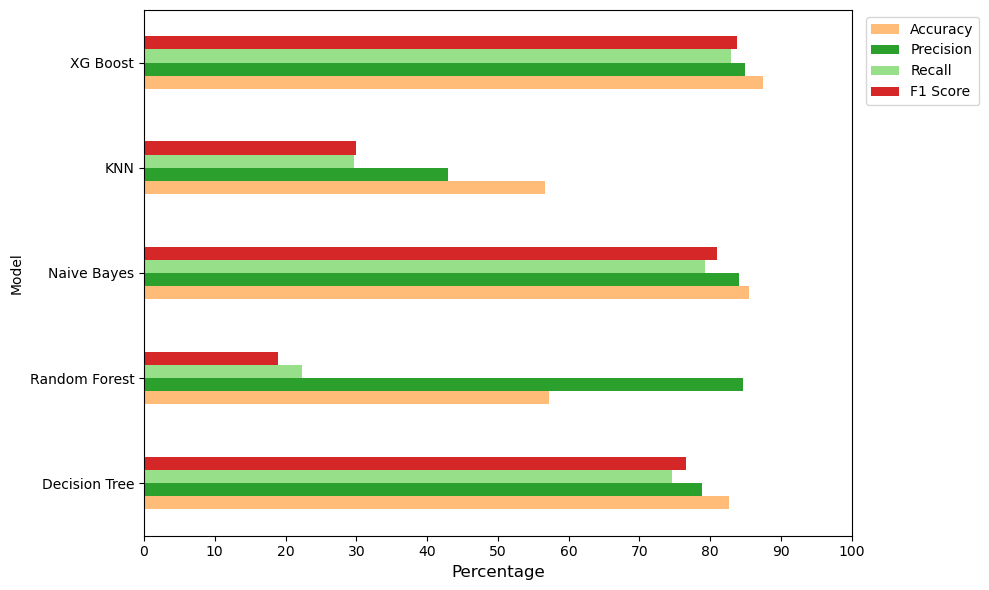

In [12]:
import matplotlib.pyplot as plt

# Create a list of tuples with the data for each model
results = [
    ('Decision Tree', 82.6, 78.9, 74.6, 76.6),
    ('Random Forest', 57.2, 84.6, 22.3, 18.9),
    ('Naive Bayes', 85.5, 84.1, 79.2, 81.0),
    ('KNN', 56.6, 42.9, 29.7, 30.0),
    ('XG Boost', 87.4, 84.9, 82.9, 83.8)
]

# Convert the data to a DataFrame and set the index to the model names
results_df = pd.DataFrame.from_records(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df.set_index('Model', inplace=True)

# Define the colors for the bars
colors = ['#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896']

# Plot the data as a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
results_df.plot.barh(ax=ax, color=colors)

# Set the x-axis limits and labels
ax.set_xlim([0, 100])
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlabel('Percentage', fontsize=12)

# Add a legend and adjust the spacing
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()

# Display the chart
plt.show()

# **Testing on recent dataset**

In [13]:
vectorizer_real = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
vect_X_real = vectorizer_real.fit_transform(X_real.squeeze())

# **Random Forest**

In [14]:
real_y_pred_rf = rdmfst.predict(vect_X_real)
scoring(y_real, real_y_pred_rf)

Accuracy: 70.6%
Precision: 14.1%
Recall: 20.0%
F1: 16.5%


/Users/akshay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Decision Tree**

In [15]:
real_y_pred = dtree.predict(vect_X_real)
scoring(y_real, real_y_pred)

Accuracy: 70.5%
Precision: 26.8%
Recall: 20.0%
F1: 16.6%


# **Naive Bayes**

In [16]:
real_y_pred = NB.predict(vect_X_real)
scoring(y_real, real_y_pred)

Accuracy: 9.7%
Precision: 22.0%
Recall: 21.6%
F1: 10.1%


# **K Nearest neighbour**

In [33]:
real_y_pred = n.predict(vect_X_real)
scoring(y_real, real_y_pred)

Accuracy: 55.6%
Precision: 20.5%
Recall: 20.5%
F1: 21.3%


# **XG Boost**

In [19]:
real_y_pred = xgb.predict(vect_X_real)
scoring(y_real, real_y_pred)

Accuracy: 70.5%
Precision: 27.3%
Recall: 20.0%
F1: 16.6%


# **Trying Count vectorizer and TFIDF with different**

In [21]:
real_X = df_test['processed_narrative']
real_y = df_test['product']

# **Gradient Boosting with TFIDF and max_feature 20,000**

In [22]:
gb_vectorizer = TfidfVectorizer(max_features=20000)
vect_X_train = gb_vectorizer.fit_transform(X_train)
vect_X_test = gb_vectorizer.transform(real_X)
gb = GradientBoostingClassifier(random_state=999, max_depth=5)
gb.fit(vect_X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=999)

In [23]:
gb_vectorizer = TfidfVectorizer(max_features=20000)
vect_X_train = gb_vectorizer.fit_transform(X_train)
vect_X_test = gb_vectorizer.transform(real_X)

In [24]:
real_y_pred = gb.predict(vect_X_test)
scoring(y_real, real_y_pred)

Accuracy: 89.8%
Precision: 83.0%
Recall: 78.3%
F1: 80.5%


In [25]:
print(classification_report(y_real ,real_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69     13084
           1       0.77      0.68      0.72     11126
           2       0.93      0.96      0.95    125237
           3       0.89      0.83      0.86     15434
           4       0.86      0.77      0.81     12627

    accuracy                           0.90    177508
   macro avg       0.83      0.78      0.81    177508
weighted avg       0.90      0.90      0.90    177508



# **Naive Bayes model**

In [26]:
nb_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=80000)
vect_X_train = nb_vectorizer.fit_transform(X_train)
vect_X_test = nb_vectorizer.transform(real_X)
nb = MultinomialNB(alpha=0.45)

In [27]:
nb.fit(vect_X_train, y_train)
real_y_pred = nb.predict(vect_X_test)
scoring(y_real, real_y_pred)

Accuracy: 87.8%
Precision: 75.1%
Recall: 82.3%
F1: 78.4%


Naive bias performs better with count vectoriser and max features of 80,000 with a F1 of 78.4%

But Gradient boosting performs better than Naive Bais with TFIDF vectoriser and max features of 20,000.

The caviat with Gradient boosting is that it takes longer than Naive bais for the training and prediction. But that trade-off can be accepted with better accuracy.

Hence finalizing Gradient boosting as a the model to be deployed.

The models are saved using Pickle to be reused.

In [35]:
# saving  model
import pickle
filename='model.sav'
pickle.dump(gb, open(filename, 'wb'))
pickle.dump(gb_vectorizer, open('TFIDF_Vect.pkl', 'wb'))